In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os
import json
import torch
from torch import tensor
import yaml
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from copy import deepcopy 
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
from scipy.spatial.transform import Rotation 
from nerfstudio.cameras.camera_optimizers import CameraOptimizer
from nerfstudio.utils.eval_utils import eval_setup
from inerf.inerf_trainer import INerfTrainer
from inerf.inerf_utils import get_corrected_pose, load_eval_image_into_pipeline, get_relative_pose, get_absolute_diff_for_pose

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
os.chdir('/workspace')
MODEL_PATH = "/workspace/outputs/jackal_training_data_1/plane-nerf/2024-01-14_115715"
EVAL_PATH = "/stored_data/test_dataset"
GROUND_TRUTH_PATH = os.path.join(EVAL_PATH, "ground_truth.json")
with open(GROUND_TRUTH_PATH) as f:
    GROUND_TRUTH = json.load(f)

In [4]:
config_path = os.path.join(MODEL_PATH, "config.yml")
config, pipeline, checkpoint_path, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )

WARNING: Using slower TCNN CutlassMLP instead of TCNN FullyFusedMLP

Use layer width of 16, 32, 64, or 128 to use the faster TCNN FullyFusedMLP.

WARNING: Using slower TCNN CutlassMLP instead of TCNN FullyFusedMLP

Use layer width of 16, 32, 64, or 128 to use the faster TCNN FullyFusedMLP.

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/jackal_training_data_1/plane-nerf/2024-01-14_115715/nerfstudio_models/step-000009999.ckpt

In [5]:
z = 2.5
pitch = 0.785
r = -2.5
init_tf = np.eye(4)
init_tf[:3, :3] = Rotation.from_rotvec(np.array([pitch, 0, 0])).as_matrix()
init_tf[0, 3] = -r
init_tf[2, 3] = z
init_tf = [init_tf]*300

In [6]:
pipeline = load_eval_image_into_pipeline(pipeline,EVAL_PATH,transform_file="transforms_trans.json")
custom_camera_optimizer = CameraOptimizer(
    config = pipeline.model.camera_optimizer.config,
    num_cameras = len(pipeline.datamanager.train_dataset),
    device = "cuda:0",
)
#custom_camera_optimizer.config.rot_l2_penalty = 0.0
#custom_camera_optimizer.config.trans_l2_penalty = 0.0
pipeline.model.camera_optimizer = custom_camera_optimizer
trainer = INerfTrainer(config)
trainer.setup_inerf(pipeline)

/workspace/inerf/inerf/inerf_utils.py:102: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  camera_to_worlds = torch.cat([camera_to_worlds, tensor([tf]).float()], 0)


Setting up training dataset...

Caching all 1 images.

Output()

[15:47:03] Saving checkpoints to:                                                                         ]8;id=975958;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=972823;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py#134\134]8;;\
           outputs/jackal_training_data_1/plane-nerf/2024-01-14_115715/nerfstudio_models                                

Loading latest Nerfstudio checkpoint from load_dir...


Done loading Nerfstudio checkpoint from 
outputs/jackal_training_data_1/plane-nerf/2024-01-14_115715/nerfstudio_models/step-000009999.ckpt

In [7]:
ground_truth_poses = []
for _ , batch in pipeline.datamanager.fixed_indices_train_dataloader:
    tf = GROUND_TRUTH["frames"][int(batch['image_idx'])]["transform_matrix"]
    tf = np.asarray(tf)
    tf = tf[:3, :4 ]
    ground_truth_poses.append(tf)
ground_truth_poses = torch.tensor(ground_truth_poses)

In [8]:
train_epoch = 100
n = 100
lr_max = 5e-3
lr_min = 1e-4
store = []
for i in range(train_epoch):
    for j in range(n):
        lr = lr_min + (lr_max - lr_min) * (i / train_epoch)
        trainer.pipeline.train()
        loss, loss_dict, metrics_dict = trainer.train_iteration_inerf(i*n + j)
    corrected_pose = get_corrected_pose(trainer)
    #print(corrected_pose)
    relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
    t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)

    #Get averrage absolute translation and rotation error
    print("Average translation error: ", torch.mean(t_diff))
    print("Average rotation error: ", torch.mean(r_diff))
    
    store.append([n*i, torch.mean(t_diff), torch.mean(r_diff)])

tensor([[[ 9.9999e-01, -2.9673e-03,  2.1013e-03,  6.0705e-01],
         [ 2.9656e-03,  1.0000e+00,  8.2274e-04,  9.3583e-03],
         [-2.1038e-03, -8.1650e-04,  1.0000e+00,  2.5013e+00]]])
Average translation error:  tensor(0.0064, dtype=torch.float64)
Average rotation error:  tensor(0.0037, dtype=torch.float64)
tensor([[[ 9.9999e-01, -4.2279e-03,  3.1447e-03,  6.0899e-01],
         [ 4.2255e-03,  9.9999e-01,  7.9183e-04,  1.0767e-02],
         [-3.1480e-03, -7.7853e-04,  9.9999e-01,  2.4990e+00]]])
Average translation error:  tensor(0.0064, dtype=torch.float64)
Average rotation error:  tensor(0.0053, dtype=torch.float64)
tensor([[[ 9.9998e-01, -4.7623e-03,  3.4957e-03,  6.0991e-01],
         [ 4.7586e-03,  9.9999e-01,  1.0881e-03,  1.2407e-02],
         [-3.5008e-03, -1.0715e-03,  9.9999e-01,  2.4985e+00]]])
Average translation error:  tensor(0.0070, dtype=torch.float64)
Average rotation error:  tensor(0.0060, dtype=torch.float64)
tensor([[[ 9.9998e-01, -4.7625e-03,  3.5304e-03,  6.

KeyboardInterrupt: 

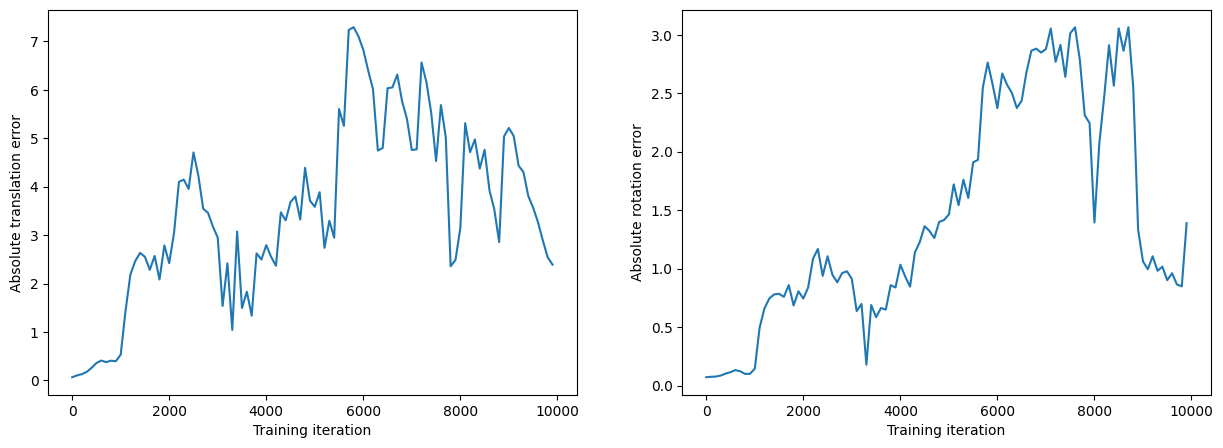

In [ ]:
#Plot store_t_diff and store_r_diff with  respect to training iteration in 2 subplots
store = np.asarray(store)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(store[:, 0], store[:, 1])
plt.xlabel("Training iteration")
plt.ylabel("Absolute translation error")
plt.subplot(1, 2, 2)
plt.plot(store[:, 0], store[:, 2])
plt.xlabel("Training iteration")
plt.ylabel("Absolute rotation error")
plt.show()

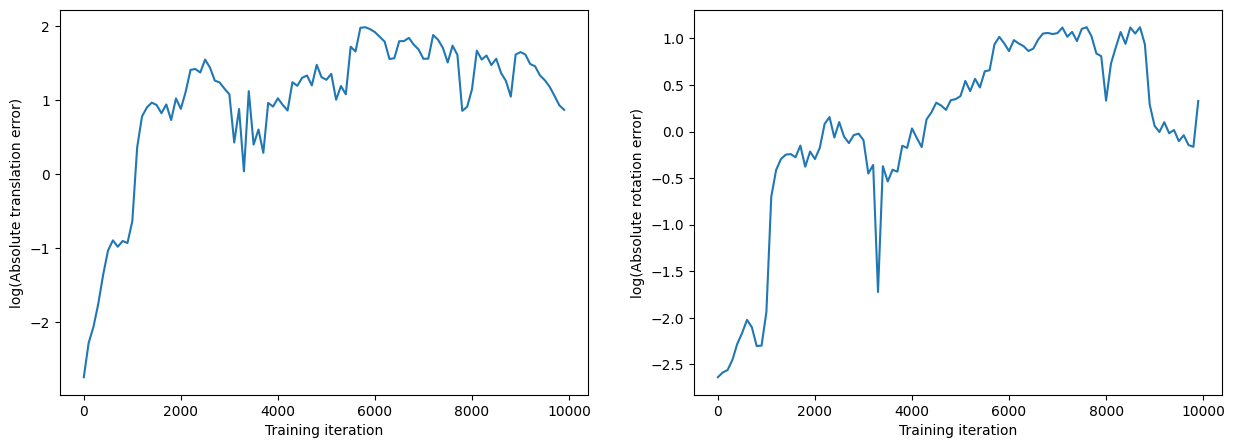

In [ ]:
#Plot store_t_diff and store_r_diff with  respect to training iteration in 2 subplots
store = np.asarray(store)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(store[:, 0], np.log(store[:, 1]))
plt.xlabel("Training iteration")
plt.ylabel("log(Absolute translation error)")
plt.subplot(1, 2, 2)
plt.plot(store[:, 0], np.log(store[:, 2]))
plt.xlabel("Training iteration")
plt.ylabel("log(Absolute rotation error)")
plt.show()